#  Masking Pipeline


"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [27]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE, HandlerBase
from eiger_io.pims_reader import EigerImages
from chxtools import handlers

## Import all the required packages for  Data Analysis

#* scikit-beam - data analysis tools for X-ray science 
#    - https://github.com/scikit-beam/scikit-beam
#* xray-vision - plotting helper functions for X-ray science
#    - https://github.com/Nikea/xray-vision

import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils

import numpy as np
from datetime import datetime
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib notebook
#%matplotlib inline

In [20]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)


In [21]:

uid = 'ffe9d518'

hdr = db[uid]

## Get the data from the uid or scan id

In [22]:
detector = 'eiger_4M_cam_img_image_lightfield'  #for old eiger images before Jan 30, 2016
#detector = 'eiger4m_image'  #for new eiger images after Jan 30, 2016


In [23]:
ev, = get_events(hdr, [detector])

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5


In [24]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)

In [25]:
imgs = ev['data'][detector]
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


## show the pixel mask

<IPython.core.display.Javascript object>


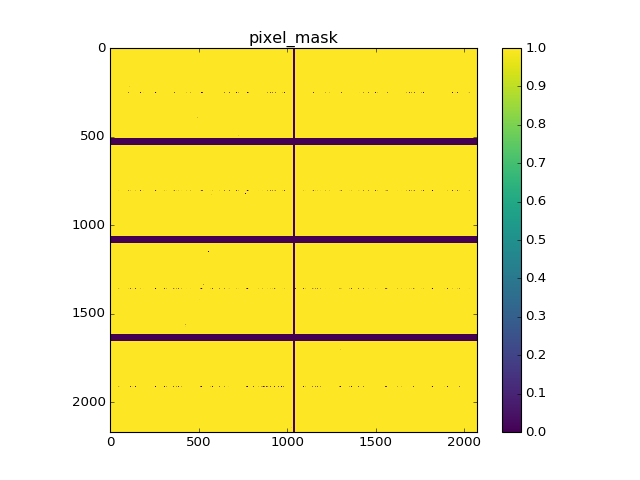

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(imgs.md['pixel_mask'], vmin=0,vmax=1,cmap='viridis')
ax.set_title( 'pixel_mask')
fig.colorbar( im )
plt.show()

## Remove hotspots in the image

In [29]:
def RemoveHot( img,threshold= 1E7 ):
    mask = np.ones_like( np.array( img )    )
    badp = np.where(  np.array(img) >= threshold )
    if len(badp[0])!=0:                
        mask[badp] = 0   
    return mask
    

In [30]:
avg_img = np.average(imgs[::500], axis=0) * imgs.md['pixel_mask']

In [31]:
mask_rh  = RemoveHot( avg_img, 5E4)

## Get the Averaged Image Data

<IPython.core.display.Javascript object>


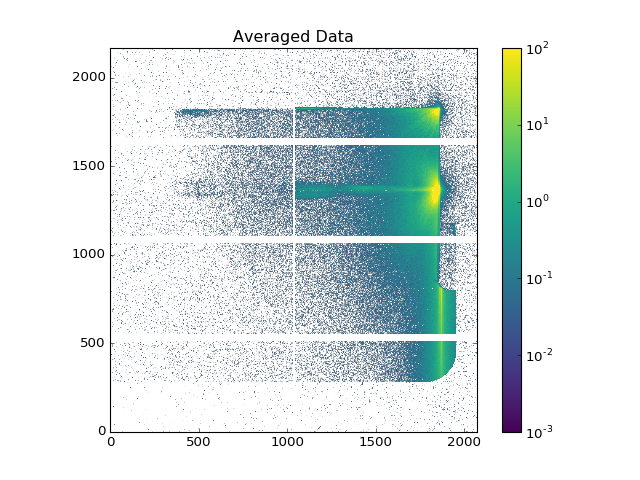

In [32]:
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img* imgs.md['pixel_mask']*mask_rh,  cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=100 ) )

fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

## Create the mask file
More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

<IPython.core.display.Javascript object>


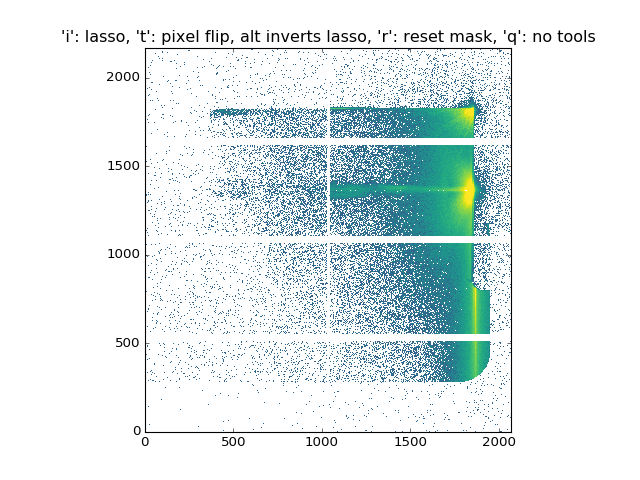

In [33]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img* imgs.md['pixel_mask']*mask_rh,
               cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=5e1 ) )
plt.show()

In [71]:
#mask = np.load( '/XF11ID/analysis/2016/2/' +  '_sandro'+"_mask_05.npy" )

<IPython.core.display.Javascript object>


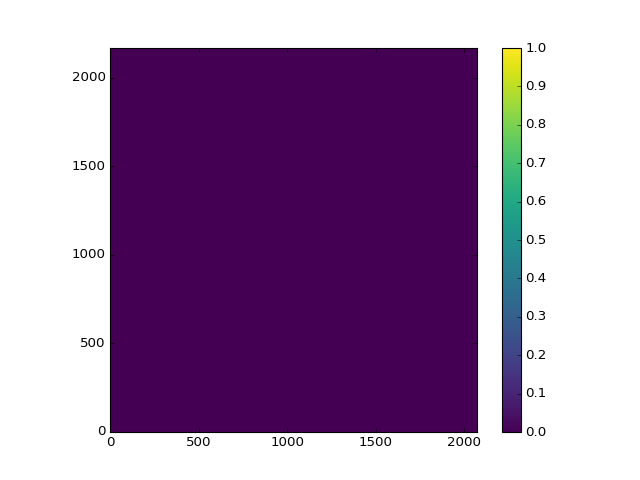

In [37]:
new_mask = m.mask
fig, ax = plt.subplots()
im=ax.imshow(new_mask,origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

# Create rectangle mask

In [39]:
'''
avg_img.shape
new_mask = np.zeros_like( avg_img , dtype = bool)
new_mask[1910:2167, 1030:1097] = True
new_mask[1948:1968, 0:2070] = True
new_mask[1660:2040, 1050:1070] = True
new_mask[0:1680, 1050:1080] = True
'''

'new_mask = np.zeros_like( avg_img , dtype = bool)\nnew_mask[1910:2167, 1030:1097] = True\nnew_mask[1948:1968, 0:2070] = True\nnew_mask[1660:2040, 1050:1070] = True\nnew_mask[0:1680, 1050:1080] = True\n'

<IPython.core.display.Javascript object>


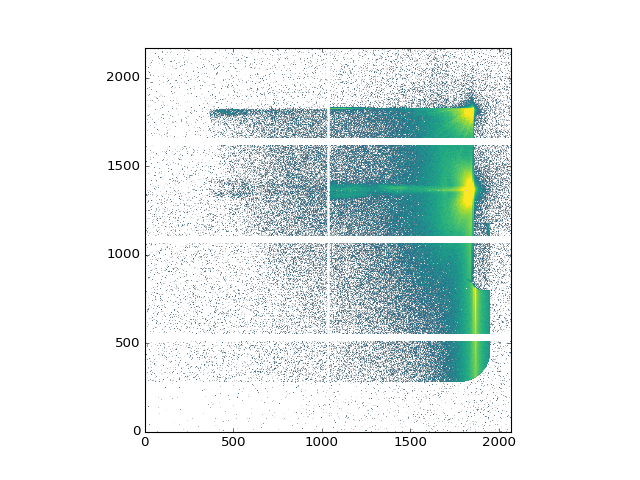

In [40]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(~new_mask* avg_img * imgs.md['pixel_mask']*mask_rh,origin='lower',
        norm= LogNorm( vmin=0.001, vmax=30 ), cmap='viridis')
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


## Combine the hand-drawn mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


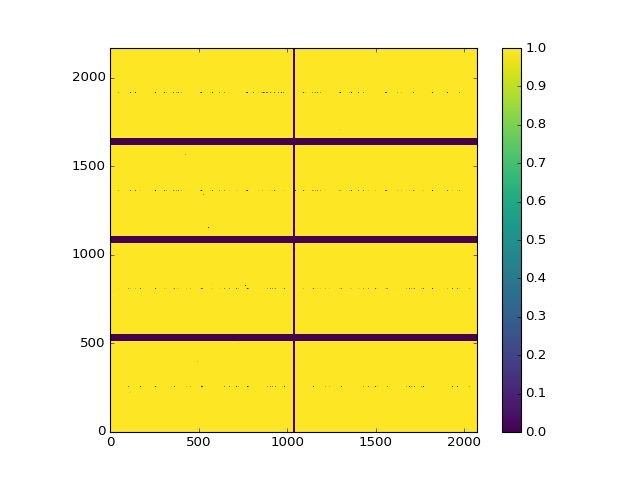

In [41]:
mask = (~new_mask)*imgs.md['pixel_mask']*mask_rh

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## save the combined mask to use in data analysis

In [68]:
np.save(  path +  str(uid)+"_mask", mask)

In [69]:
#np.save(  '/XF11ID/analysis/2016/2/' +  '_sandro'+"_mask", mask)
#np.save(  '/XF11ID/analysis/2016/2/' +  '_sandro'+"_mask_05", mask)

In [39]:
#path